In [1]:
# Import libaries
import numpy as np                      
import matplotlib.pyplot as plt 

In [23]:
# Laplace functions

def laplace_2D(matrix, electrodes):

    # Calculate Laplace
    new_matrix = (1/4) * ( matrix[2:, 1:-1] + matrix[:-2, 1:-1] +   matrix[1:-1, 2:] + matrix[1:-1, :-2] )

    # Update while keeping electrodes unchanged
    matrix[1:-1, 1:-1][~electrodes[1:-1, 1:-1]] = new_matrix[~electrodes[1:-1, 1:-1]]

    matrix[   0, 1:-1] = matrix[   1, 1:-1]
    matrix[  -1, 1:-1] = matrix[  -2, 1:-1]
    matrix[1:-1,    0] = matrix[1:-1,    1]
    matrix[1:-1,   -1] = matrix[1:-1,   -2]

    return matrix

def corners_2D(matrix):
    
    matrix[ 0, 0] = 0.5 * (matrix[ 1, 0] + matrix[ 0, 1])
    matrix[-1, 0] = 0.5 * (matrix[-2, 0] + matrix[-1, 1])
    matrix[ 0,-1] = 0.5 * (matrix[ 1,-1] + matrix[ 0,-2])
    matrix[-1,-1] = 0.5 * (matrix[-2,-1] + matrix[-1,-2])

    return matrix

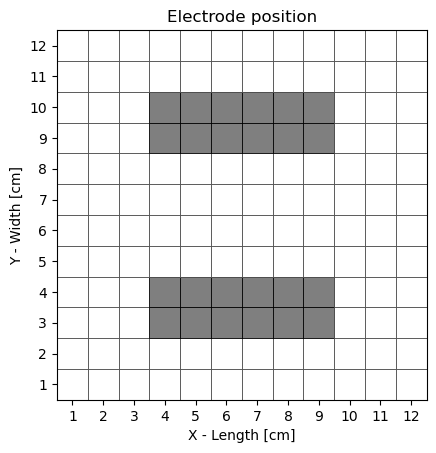

Number of loops: 403


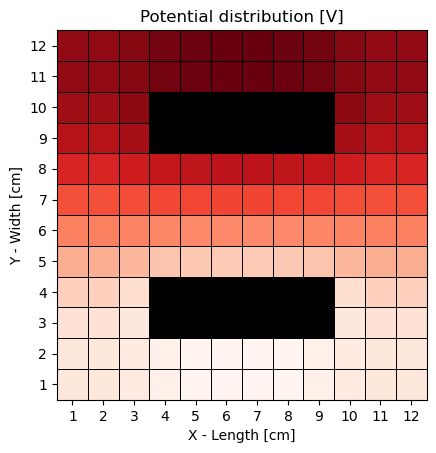

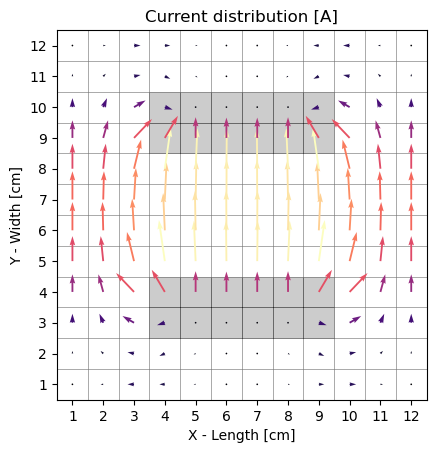

3.2265407099
3.2265407102
7.2033727195
7.20337272


In [24]:
# ===== Input =====
x = 12  # Grid size in x-direction
y = 12  # Grid size in y-direction
h = 1   # Resolution factor (higher h -> finer resolution)

cat_pos_x = slice(2 * h, 4 * h)
ano_pos_x = slice(8 * h, 10 * h)

cat_pos_y = slice(3 * h, 9 * h)
ano_pos_y = slice(3 * h, 9 * h)

cat_pot = 0  # V
ano_pot = 1  # V
# =================

# Create the grid with resolution scaling
x_res = x * h
y_res = y * h
V = np.zeros((x_res, y_res))
V = np.transpose(V)

# Set electrode potentials
V[cat_pos_x, cat_pos_y] = cat_pot  
V[ano_pos_x, ano_pos_y] = ano_pot

# Mark electrode positions
electrodes = np.zeros_like(V, dtype=bool)
electrodes[cat_pos_x, cat_pos_y] = True
electrodes[ano_pos_x, ano_pos_y] = True

# Plot electrode positions
plt.pcolormesh(1 * electrodes, cmap='Greys', alpha=0.5, edgecolors='k', linewidth=0.5)
plt.gca().set_aspect('equal')
plt.title('Electrode position')
plt.xlabel('X - Length [cm]')
plt.ylabel('Y - Width [cm]')
plt.xticks(ticks=np.arange(0.5*h, x_res + 0.5*h, h), labels=np.arange(1, x + 1))
plt.yticks(ticks=np.arange(0.5*h, y_res + 0.5*h, h), labels=np.arange(1, y + 1))
plt.show()

# Laplace 
tolerance = 1e-12
error = 2*tolerance
count = 0

while error > tolerance:

    V_old = V.copy()

    V = laplace_2D(V, electrodes)

    count += 1
    error = np.max(np.abs(V-V_old))

print(f'Number of loops: {count}')
V = corners_2D(V)

plt.pcolormesh(V, cmap='Reds', alpha=1, edgecolors='k', linewidth=0.5)
plt.pcolormesh(np.ma.masked_where(electrodes == 0, electrodes), cmap='bone', alpha=1, edgecolors='k', linewidth=0.5)
plt.gca().set_aspect('equal')
plt.title('Potential distribution [V]')
plt.xlabel('X - Length [cm]')
plt.ylabel('Y - Width [cm]')
plt.xticks(ticks=np.arange(0.5*h, x_res + 0.5*h, h), labels=np.arange(1, x + 1))
plt.yticks(ticks=np.arange(0.5*h, y_res + 0.5*h, h), labels=np.arange(1, y + 1))
plt.show()

# Current
Ex, Ey = np.gradient(V)
sigma = (1/h)* 4.24 #1/cm ohm
I = sigma * np.sqrt(Ex**2 + Ey**2)

plt.pcolormesh(1*electrodes, cmap='Greys', alpha = 0.2, edgecolors='k', linewidth=0.5)
plt.quiver(np.arange(1, Ex.shape[1] + 1) - 0.5, np.arange(1, Ex.shape[0] + 1)-0.5, Ey, Ex, I, cmap = 'magma')
plt.gca().set_aspect('equal')
plt.title('Current distribution [A]')
plt.xlabel('X - Length [cm]')
plt.ylabel('Y - Width [cm]')
plt.xticks(ticks=np.arange(0.5*h, x_res + 0.5*h, h), labels=np.arange(1, x + 1))
plt.yticks(ticks=np.arange(0.5*h, y_res + 0.5*h, h), labels=np.arange(1, y + 1))
plt.show()

# Current inside
cat_cur = np.sum(np.sum(I[ cat_pos_x.start,        cat_pos_y])+
                 np.sum(I[cat_pos_x.stop-1,        cat_pos_y])+
                 np.sum(I[       cat_pos_x,  cat_pos_y.start])+
                 np.sum(I[       cat_pos_x, cat_pos_y.stop-1])-
                 np.sum(I[ cat_pos_x.start,  cat_pos_y.start])-
                 np.sum(I[cat_pos_x.stop-1,  cat_pos_y.start])-
                 np.sum(I[ cat_pos_x.start, cat_pos_y.stop-1])-
                 np.sum(I[cat_pos_x.stop-1, cat_pos_y.stop-1]))
print(np.round(cat_cur,10))

ano_cur = np.sum(np.sum(I[ ano_pos_x.start,        ano_pos_y])+
                 np.sum(I[ano_pos_x.stop-1,        ano_pos_y])+
                 np.sum(I[       ano_pos_x,  ano_pos_y.start])+
                 np.sum(I[       ano_pos_x, ano_pos_y.stop-1])-
                 np.sum(I[ ano_pos_x.start,  ano_pos_y.start])-
                 np.sum(I[ano_pos_x.stop-1,  ano_pos_y.start])-
                 np.sum(I[ ano_pos_x.start, ano_pos_y.stop-1])-
                 np.sum(I[ano_pos_x.stop-1, ano_pos_y.stop-1]))
print(np.round(ano_cur,10))

# Current outside
cat_cur = np.sum(np.sum(I[cat_pos_x.start-1,         cat_pos_y])+
                 np.sum(I[   cat_pos_x.stop,         cat_pos_y])+
                 np.sum(I[        cat_pos_x, cat_pos_y.start-1])+
                 np.sum(I[       cat_pos_x,     cat_pos_y.stop]))
print(np.round(cat_cur,10))
ano_cur = np.sum(np.sum(I[ano_pos_x.start-1,         ano_pos_y])+
                 np.sum(I[   ano_pos_x.stop,         ano_pos_y])+
                 np.sum(I[        ano_pos_x, ano_pos_y.start-1])+
                 np.sum(I[       ano_pos_x,     ano_pos_y.stop]))
print(np.round(ano_cur,10))